In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

In [34]:
import os
import glob

dataset_dir = "../dataset"

pattern = os.path.join(dataset_dir, "*.csv")
files = glob.glob(pattern)


season_dfs = {}
for path in files:
    fname= os.path.basename(path)
    if not (fname.startswith("Season ")or fname.startswith("20")or fname.startswith("epl-2024-2025")):
        continue
    if fname.startswith("Season "):
        raw = fname[len("Season"):-4]
        season = raw[:4]+ "_" + raw[4:]
    elif fname.startswith("epl-2024-2025"):
        season="2024_25"
    else:
        raw = fname[:-4]
        season = raw[:4] + " " + raw[4:]
    season_dfs[season] = pd.read_csv(path)

    combined = pd.concat([df.assign(season=season) for season,df in season_dfs.items()], ignore_index=True)

In [35]:
combined.to_csv("../dataset/epl_all_seasons_2009_25.csv", index=False)

In [2]:
df = pd.read_csv("../dataset/epl_all_seasons_2009_25.csv")

In [3]:
df.head()

,Div,Date,Time,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,...,AST,HF,AF,HC,AC,HY,AY,HR,AR,season
0,E0,11/8/2023,20:00,Burnley,Man City,0.0,3.0,A,0.0,2.0,...,8.0,11.0,8.0,6.0,5.0,0.0,0.0,1.0,0.0,2023 2024
1,E0,12/8/2023,12:30,Arsenal,Nott'm Forest,2.0,1.0,H,2.0,0.0,...,2.0,12.0,12.0,8.0,3.0,2.0,2.0,0.0,0.0,2023 2024
2,E0,12/8/2023,15:00,Bournemouth,West Ham,1.0,1.0,D,0.0,0.0,...,3.0,9.0,14.0,10.0,4.0,1.0,4.0,0.0,0.0,2023 2024
3,E0,12/8/2023,15:00,Brighton,Luton,4.0,1.0,H,1.0,0.0,...,3.0,11.0,12.0,6.0,7.0,2.0,2.0,0.0,0.0,2023 2024
4,E0,12/8/2023,15:00,Everton,Fulham,0.0,1.0,A,0.0,0.0,...,2.0,12.0,6.0,10.0,4.0,0.0,2.0,0.0,0.0,2023 2024


In [4]:
df.isnull().sum()

Div            1
Date           1
Time        3801
HomeTeam       1
AwayTeam       1
FTHG           1
FTAG           1
FTR            1
HTHG           1
HTAG           1
HTR            1
Referee        1
HS             1
AS             1
HST            1
AST            1
HF             1
AF             1
HC             1
AC             1
HY             1
AY             1
HR             1
AR             1
season         0
dtype: int64

In [5]:
df.drop(columns=["Time"], inplace=True)

In [6]:
df.isnull().sum()

Div         1
Date        1
HomeTeam    1
AwayTeam    1
FTHG        1
FTAG        1
FTR         1
HTHG        1
HTAG        1
HTR         1
Referee     1
HS          1
AS          1
HST         1
AST         1
HF          1
AF          1
HC          1
AC          1
HY          1
AY          1
HR          1
AR          1
season      0
dtype: int64

In [7]:
df_clean = df.dropna()

In [9]:
numeric_cols = df_clean.select_dtypes(include=['int64', 'float64']).columns
print("\nNumeric summary:\n", df_clean[numeric_cols].describe())

cat_cols = df.select_dtypes(include=['object', 'category']).columns
for col in cat_cols:
    print(f"\nValue counts for {col}:\n", df[col].value_counts().head(5))



Numeric summary:
               FTHG         FTAG         HTHG         HTAG           HS  \
count  6080.000000  6080.000000  6080.000000  6080.000000  6080.000000   
mean      1.574836     1.227138     0.702632     0.544572    14.090461   
std       1.320990     1.185766     0.851381     0.755951     5.585452   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       1.000000     0.000000     0.000000     0.000000    10.000000   
50%       1.000000     1.000000     0.000000     0.000000    13.000000   
75%       2.000000     2.000000     1.000000     1.000000    17.000000   
max       9.000000     9.000000     5.000000     5.000000    43.000000   

                AS          HST          AST           HF           AF  \
count  6080.000000  6080.000000  6080.000000  6080.000000  6080.000000   
mean     11.405592     5.569572     4.522862    10.583882    11.063487   
std       4.926033     3.206666     2.752403     3.438344     3.607934   
min       0.000000

In [10]:
df_clean["season"].value_counts().sort_index()


season
 200_92010    380
 201_02011    380
 201_12012    380
 201_22013    380
 201_32014    380
 201_42015    380
 201_52016    380
 201_62017    380
 201_72018    380
 201_82019    380
 201_92020    380
 202_02021    380
 202_12022    380
 202_22023    380
2023 2024     380
2024_25       380
Name: count, dtype: int64

In [11]:
all_teams = df_clean["HomeTeam"].unique()
team_home_stats = []
team_away_stats =[]
for team in all_teams:
    home_games = df_clean[df_clean["HomeTeam"] == team]
    total_home_games = len(home_games)
    wins = home_games[home_games["FTR"] == "H"].shape[0]
    draws = home_games[home_games["FTR"] == "D"].shape[0]
    losses = home_games[home_games["FTR"] == "A"].shape[0]
    played_against = [home_games["AwayTeam"]]
    
    goals_for = home_games["FTHG"].sum()
    goals_against = home_games["FTAG"].sum()
    
    team_home_stats.append({
        "team": team,
        "home_games": total_home_games,
        "home_wins": wins,
        "home_draws": draws,
        "home_losses": losses,
        "goals_for_at_home": goals_for,
        "goals_against_at_home": goals_against,
        
    })

    away_games = df_clean[df_clean["AwayTeam"] == team]
    total_away_games = len(away_games)

    
    away_wins   = away_games[away_games["FTR"] == "A"].shape[0]
    away_draws  = away_games[away_games["FTR"] == "D"].shape[0]
    away_losses = away_games[away_games["FTR"] == "H"].shape[0]
    
    goals_for_away     = away_games["FTAG"].sum()
    goals_against_away = away_games["FTHG"].sum()

    team_away_stats.append({
        "team": team,
        "away_games": total_away_games,
        "away_wins": away_wins,
        "away_draws": away_draws,
        "away_losses": away_losses,
        "goals_for_away": goals_for_away,
        "goals_against_away": goals_against_away,
        
    })


In [13]:
team_home_df= pd.DataFrame(team_home_stats)
team_away_df= pd.DataFrame(team_away_stats)

In [21]:
team_stats_df = pd.merge(team_home_df, team_away_df, on='team')
team_stats_df['total_wins'] = team_stats_df['home_wins'] + team_stats_df['away_wins']
team_stats_df['total_goals_for'] = team_stats_df['goals_for_at_home'] + team_stats_df['goals_for_away']
team_stats_df['total_goals_against'] = team_stats_df['goals_against_at_home'] + team_stats_df['goals_against_away']
team_stats_df.head()

,team,home_games,home_wins,home_draws,home_losses,goals_for_at_home,goals_against_at_home,away_games,away_wins,away_draws,away_losses,goals_for_away,goals_against_away,total_wins,total_goals_for,total_goals_against
0,Burnley,171,58,40,73,190.0,234.0,171,35,45,91,161.0,294.0,93,351.0,528.0
1,Arsenal,304,202,62,40,653.0,281.0,304,135,74,95,497.0,398.0,337,1150.0,679.0
2,Bournemouth,171,60,45,66,228.0,250.0,171,44,31,96,202.0,329.0,104,430.0,579.0
3,Brighton,152,54,52,46,199.0,204.0,152,40,46,66,183.0,236.0,94,382.0,440.0
4,Everton,304,145,81,78,466.0,340.0,304,73,98,133,325.0,456.0,218,791.0,796.0


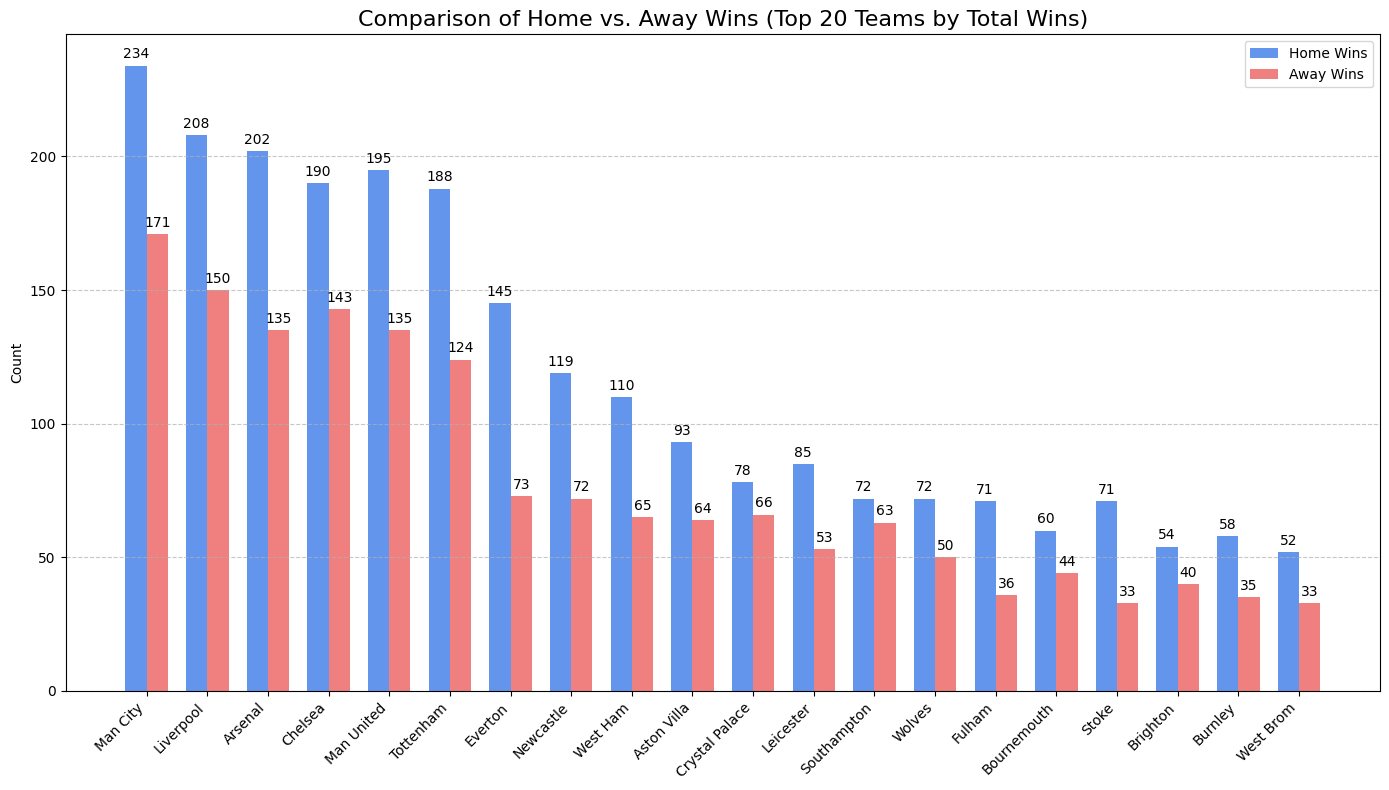

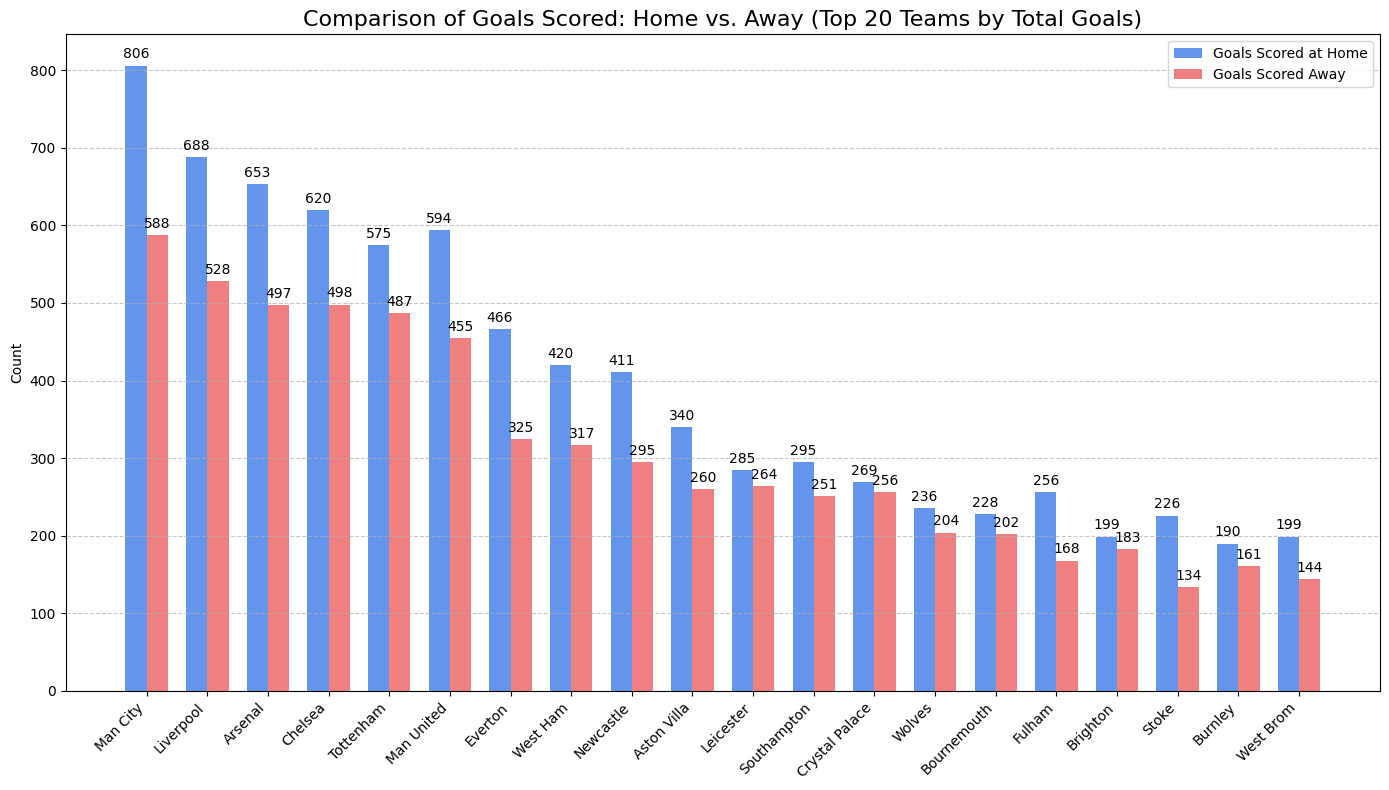

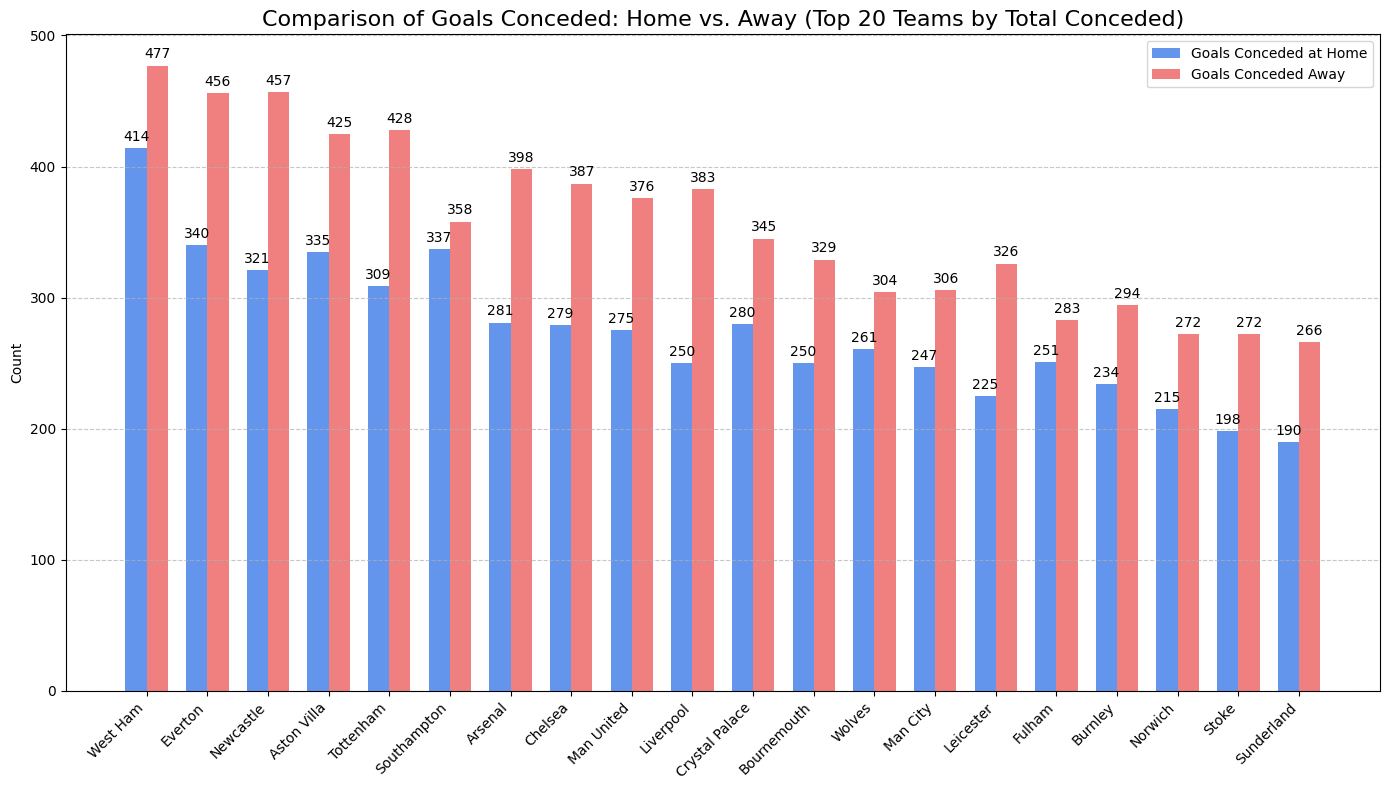

In [22]:
def plot_comparison_chart(df, y_vars, y_labels, title, sort_by, top_n=20):
    df_sorted = df.sort_values(by=sort_by, ascending=False).head(top_n)
    
   
    x = np.arange(len(df_sorted['team']))  
    width = 0.35 

    fig, ax = plt.subplots(figsize=(14, 8))
    rects1 = ax.bar(x - width/2, df_sorted[y_vars[0]], width, label=y_labels[0], color='cornflowerblue')
    rects2 = ax.bar(x + width/2, df_sorted[y_vars[1]], width, label=y_labels[1], color='lightcoral')

    ax.set_ylabel('Count')
    ax.set_title(title, fontsize=16)
    ax.set_xticks(x)
    ax.set_xticklabels(df_sorted['team'], rotation=45, ha='right')
    ax.legend()
    ax.grid(axis='y', linestyle='--', alpha=0.7)

    ax.bar_label(rects1, padding=3)
    ax.bar_label(rects2, padding=3)

    fig.tight_layout()
    plt.show()

plot_comparison_chart(
    df=team_stats_df,
    y_vars=['home_wins', 'away_wins'],
    y_labels=['Home Wins', 'Away Wins'],
    title='Comparison of Home vs. Away Wins (Top 20 Teams by Total Wins)',
    sort_by='total_wins'
)

plot_comparison_chart(
    df=team_stats_df,
    y_vars=['goals_for_at_home', 'goals_for_away'],
    y_labels=['Goals Scored at Home', 'Goals Scored Away'],
    title='Comparison of Goals Scored: Home vs. Away (Top 20 Teams by Total Goals)',
    sort_by='total_goals_for'
)

plot_comparison_chart(
    df=team_stats_df,
    y_vars=['goals_against_at_home', 'goals_against_away'],
    y_labels=['Goals Conceded at Home', 'Goals Conceded Away'],
    title='Comparison of Goals Conceded: Home vs. Away (Top 20 Teams by Total Conceded)',
    sort_by='total_goals_against'
)